In [8]:
#-- For data handling
import xarray as xr
import pandas as pd
import numpy as np
#-- For plotting
from matplotlib import pyplot as plt
import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

# Open tas MIROC6 files through opendap

In [2]:
tas1 = xr.open_dataset('http://esgf-data2.diasjp.net/thredds/dodsC/esg_dataroot/CMIP6/CMIP/MIROC/MIROC6/historical/r1i1p1f1/Amon/tas/gn/v20181212/tas_Amon_MIROC6_historical_r1i1p1f1_gn_185001-194912.nc', decode_times=True)
tas2 = xr.open_dataset('http://esgf-data2.diasjp.net/thredds/dodsC/esg_dataroot/CMIP6/CMIP/MIROC/MIROC6/historical/r1i1p1f1/Amon/tas/gn/v20181212/tas_Amon_MIROC6_historical_r1i1p1f1_gn_195001-201412.nc', decode_times=True)
tas = xr.concat([tas1,tas2], dim='time')

# Seasonal means

In [70]:
# Seasonal mean
tas_seas = tas['tas'].groupby('time.season').mean('time') - 273.15

# Quick plot with xarray

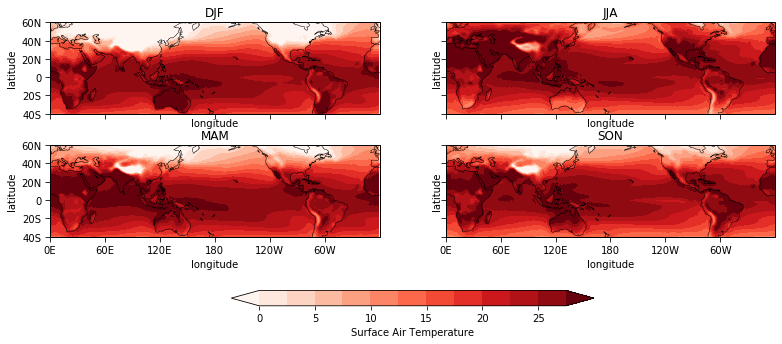

In [95]:
fig, ax = plt.subplots(2, 2, figsize=(13,4),subplot_kw=dict(projection=ccrs.PlateCarree(central_longitude=180.0)),sharex = True, sharey = True)
ax = ax.flatten()

cmap = plt.get_cmap('Reds')
for itr,axi in enumerate(ax) :
    
    cf = tas_seas.isel(season=itr).plot.contourf(ax=axi, cmap=cmap, transform=ccrs.PlateCarree(),extend="both", add_colorbar = False,
                                           levels=np.arange(0,30,2.5))

    limits = (0,359,-40,60)
    xaxis_interval = 60
    yaxis_interval = 20
 
    axi.coastlines(linewidth=0.5)
    axi.set_title(tas_seas.isel(season=itr)['season'].values)
    axi.set_extent(limits)
    axi.set_xticks(np.arange(limits[0],limits[1]+1,xaxis_interval), crs=ccrs.PlateCarree())
    axi.set_yticks(np.arange(limits[2],limits[3]+1,yaxis_interval), crs=ccrs.PlateCarree())
    lon_formatter = LongitudeFormatter(zero_direction_label=True, degree_symbol='')
    lat_formatter = LatitudeFormatter(degree_symbol='')
    axi.xaxis.set_major_formatter(lon_formatter)
    axi.yaxis.set_major_formatter(lat_formatter)
    axi.tick_params(direction = 'out', length = 5)
    axi.set_aspect('equal', 'box')
    axi.set_xlabel('longitude')
    axi.set_ylabel('latitude')

cbar = fig.colorbar(cf,ax = ax, orientation = 'horizontal',extendfrac='auto', shrink=0.5, anchor=(0.5,-4), label = 'Surface Air Temperature',)
plt.subplots_adjust(hspace=0.3)
plt.savefig('tas_seasons.png', orientation='landscape',dpi=100)

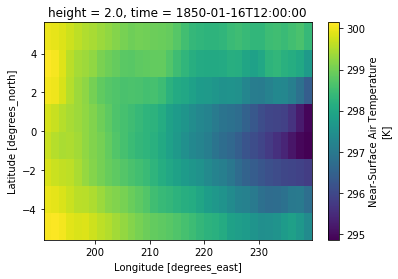

In [97]:
# Selection per slice and position
nino34_area = tas.sel(lat=slice(-5,5), lon=slice(190,240))
nino34_area['tas'].isel(time=0).plot()

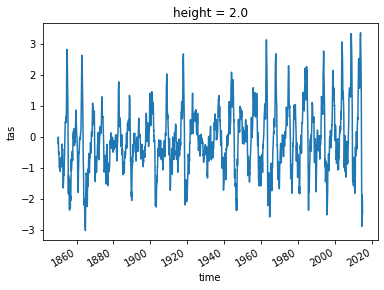

In [99]:
# NINO3.4 index
baseline = nino34_area.sel(time=slice('1961','1990'))
baseline_average = baseline.groupby('time.month').mean(dim='time')

anomaly = nino34_area.groupby('time.month') - baseline_average
nino34_index = anomaly.mean(dim=('lat','lon'))
nino34_index['tas'].plot()

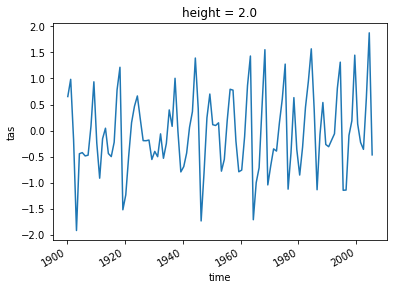

In [104]:
nino34_index = nino34_index.resample(time='6MS').mean().sel(time = slice('1850-06','2014-12',2)) 
nino34_index['tas'].plot()
ntime = nino34_index.dims['time']

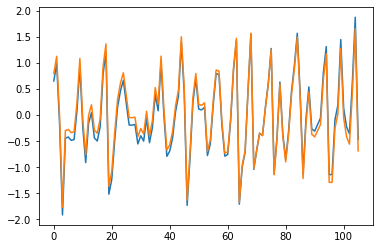

In [111]:
#-- Detrending
z = np.polyfit(x = np.arange(ntime), y = nino34_index.tas, deg = 2)
zza = np.polyval(z,np.arange(ntime))
plt.plot(nino34_index.tas)
plt.plot(nino34_index.tas-zza)

In [75]:
tas_seas

<xarray.DataArray 'tas' (season: 4, lat: 128, lon: 256)>
array([[[-20.18779 , -20.217133, ..., -20.13089 , -20.159058],
        [-19.334305, -19.417175, ..., -19.166245, -19.250595],
        ...,
        [-30.623077, -30.604538, ..., -30.662643, -30.642105],
        [-31.125183, -31.119583, ..., -31.138046, -31.13063 ]],

       [[-53.621475, -53.664047, ..., -53.537918, -53.579315],
        [-50.829803, -50.913345, ..., -50.657516, -50.74469 ],
        ...,
        [ -0.869324,  -0.861206, ...,  -0.886871,  -0.877655],
        [ -0.998779,  -0.997375, ...,  -1.002716,  -1.000458]],

       [[-50.78511 , -50.82921 , ..., -50.697525, -50.741226],
        [-48.178925, -48.29152 , ..., -47.95317 , -48.06627 ],
        ...,
        [-22.914368, -22.897308, ..., -22.94905 , -22.931503],
        [-23.282288, -23.278702, ..., -23.29158 , -23.28598 ]],

       [[-42.476776, -42.51599 , ..., -42.399216, -42.43782 ],
        [-40.8407  , -40.9198  , ..., -40.677658, -40.760284],
        ...,
   